In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

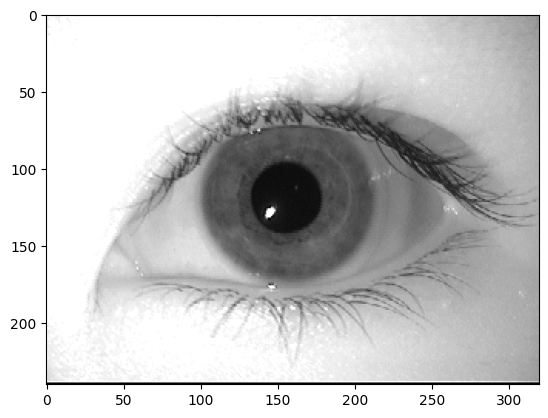

In [2]:
sample_eye_image = cv2.imread('MMU-Iris-Database/1/left/aeval1.bmp')
sample_eye_image = cv2.cvtColor(sample_eye_image, cv2.COLOR_BGR2GRAY)
plt.imshow(sample_eye_image , cmap='gray')

## Pupil Segmentation

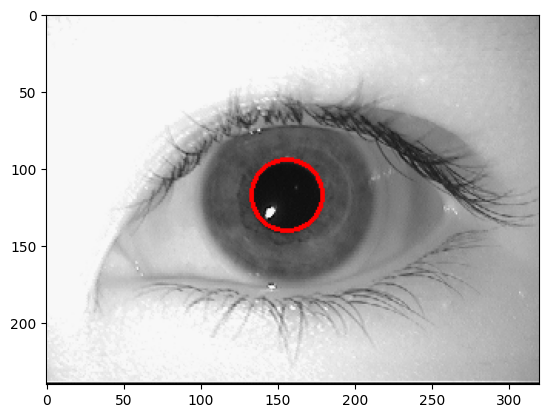

In [3]:
'''Step - 1 : Inverse the image'''
inv_eye_image = cv2.bitwise_not(sample_eye_image)
# plt.imshow(sample_eye_image , cmap='gray')
# plt.title("Inverse Image")

'''Step - 2 : Threshold = 0.9 on inverse image'''
ret, thresh = cv2.threshold(inv_eye_image, 0.9*255, 255, cv2.THRESH_BINARY)
# plt.imshow(thresh , cmap = 'gray')

'''Step - 3 : Erosion with a circular structural element'''
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
eroded_img = cv2.erode(thresh,kernel,iterations = 50)
# plt.imshow(eroded_img , cmap = 'gray')

'''Step - 4 : Finding the largest connected component'''
# Find all your connected components (white blobs in your image)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(eroded_img, connectivity=8)
# Get the component with largest area
max_label = 1
max_area = stats[1, cv2.CC_STAT_AREA]
for i in range(2, nb_components):
    if stats[i, cv2.CC_STAT_AREA] > max_area:
        max_label = i
        max_area = stats[i, cv2.CC_STAT_AREA]

# Get the x,y coordinates of the centroid of the largest component
centroids = centroids.astype(int)
x, y = centroids[max_label]
radius = int(np.sqrt(max_area/np.pi)) + 2

# Draw a thick red circle around the largest component
img_circle = cv2.cvtColor(sample_eye_image, cv2.COLOR_GRAY2RGB)
cv2.circle(img_circle, (x, y), radius, (255 ,0 ,0), 2)
plt.imshow(img_circle)


In [4]:
print(radius)

23


## Iris Segmentation

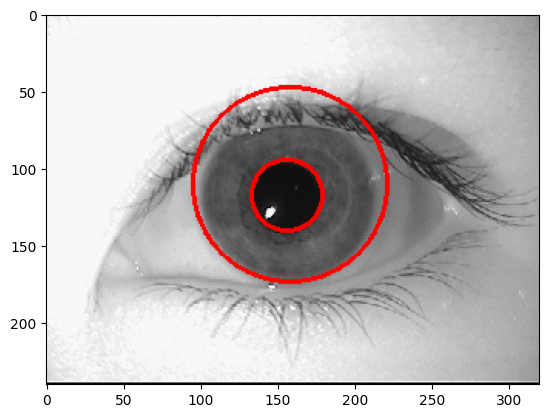

In [5]:
'''Step 1 : Gamma correction with gamma = 3'''
gamma = 3
img_gamma = np.power(sample_eye_image / 255, gamma)*255
img_gamma = np.array(img_gamma, dtype = np.uint8)
# plt.imshow(img_gamma , cmap = 'gray')

'''Step - 2 : Process with median filter'''
img_median = cv2.medianBlur(img_gamma, 5)
# plt.imshow(img_median , cmap = 'gray')

'''Step - 3 : Circular Hough Transform'''
circles = cv2.HoughCircles(img_median,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=radius,maxRadius=3*radius)
if circles is None:
    print("No circle found")
else:
    circles = np.uint16(np.around(circles))
    img_circle = cv2.cvtColor(sample_eye_image, cv2.COLOR_GRAY2RGB)
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(img_circle,(i[0],i[1]),i[2],(255,0,0),2)
        # draw the center of the circle
        cv2.circle(img_circle,(i[0],i[1]),2,(255,0,0),3)
plt.imshow(img_circle)
   
'''Step - 4 : Filter circles with offset from iris < 20'''
iris_circles = []
for i in circles[0,:]:
    if np.sqrt((i[0]-x)**2 + (i[1]-y)**2) < 20:
        iris_circles.append(i)
iris_circles = np.array(iris_circles)
img_circle = cv2.cvtColor(sample_eye_image, cv2.COLOR_GRAY2RGB)
for i in iris_circles:
    # draw the outer circle
    cv2.circle(img_circle,(i[0],i[1]),i[2],(255,0,0),2)
    # draw the center of the circle
    cv2.circle(img_circle,(i[0],i[1]),2,(255,0,0),3)
plt.imshow(img_circle)

'''Step - 5 : Choose the circle with the largest radius'''
iris_circle = iris_circles[np.argmax(iris_circles[:,2])]
img_circle = cv2.cvtColor(sample_eye_image, cv2.COLOR_GRAY2RGB)
# draw the outer circle
cv2.circle(img_circle,(iris_circle[0],iris_circle[1]),iris_circle[2],(255,0,0),2)
# draw the center of the circle
# cv2.circle(img_circle,(iris_circle[0],iris_circle[1]),2,(255,0,0),3)
# Draw pupul circle also
cv2.circle(img_circle,(x,y),radius,(255,0,0),2)
plt.imshow(img_circle)

In [6]:
print(iris_circle[2])

63


## Iris Normalisation

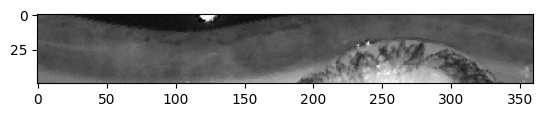

In [7]:
r_out = iris_circle[2] # Radius of outer circle : Iris (approx 63)
r_in = radius # Radius of inner circle : Pupil (approx 23)

height = 50
width = 360

'''Step - 1 : Rubber sheet model'''
img_rubber = np.zeros((height,width,3), np.uint8)
thetas = np.linspace(0, 2*np.pi, width)

for i in range(height):
    for j in range(width):
        r = r_in + (r_out - r_in)*i/height
        x = int(r*np.cos(thetas[j]) + iris_circle[0])
        y = int(r*np.sin(thetas[j]) + iris_circle[1])
        img_rubber[i,j] = sample_eye_image[y,x]
plt.imshow(img_rubber , cmap = 'gray')


## Occlusion Removal

### Eyelash Detection

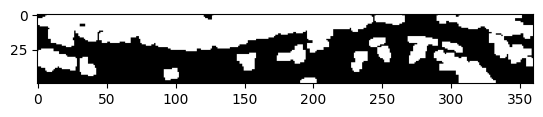

In [8]:
'''Step - 1 : Inverse the image and threshold = 0.9 on inverse image'''
img_rubber_g = cv2.cvtColor(img_rubber, cv2.COLOR_BGR2GRAY)
inv_eye_image = cv2.bitwise_not(img_rubber_g)
ret, thresh2 = cv2.threshold(inv_eye_image, 0.7*255, 255, cv2.THRESH_BINARY)

'''Step - 2 : Erosion with a circular structural element'''
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
eroded_img2 = cv2.erode(thresh2,kernel,iterations = 1)

'''Step - 3 : Remove connected components with number of pixels < 10'''
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(eroded_img2, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = 10
img_cleaned = np.zeros((output.shape))
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_cleaned[output == i + 1] = 255
plt.imshow(img_cleaned , cmap = 'gray')

'''Step - 4 : Dilate the image with a 4x4 square structural element'''
kernel = np.ones((4,4),np.uint8)
img_dilated = cv2.dilate(img_cleaned,kernel,iterations = 1)
plt.imshow(img_dilated , cmap = 'gray')

### Exclusion by parabolic projection

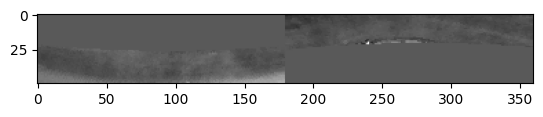

In [9]:
'''Step - 1 : Divide the image into left and right halves'''
img_left = img_dilated[:, :180].astype(np.uint8)
img_right = img_dilated[:, 180:].astype(np.uint8)


'''Step - 2 : For the left side, estimate the coefficients a, b, c which
minimize the least-square error with the parabolic
equation: y = ax^2 + bx + c'''
edges_left = cv2.Canny(img_left, 30 , 70, apertureSize = 3)
# now fit a parabolic curve to the left half of the image with eq : y = ax^2 + bx + c
indices_left = np.where(edges_left != [0])
x_left = indices_left[1]
y_left = indices_left[0]
A_left = np.array([x_left**2, x_left, np.ones(len(x_left))]).T
B_left = y_left
a_left, b_left, c_left = np.linalg.lstsq(A_left, B_left,rcond=None)[0]

# draw this parabola on image
# img_left = cv2.cvtColor(img_left, cv2.COLOR_GRAY2RGB)
# for i in range(0, img_left.shape[1]):
#     y = int(a_left*i**2 + b_left*i + c_left)
#     img_left[y, i] = [255, 0, 0]
# plt.imshow(img_left)

'''Step - 3 : For the right side, estimate the coefficients a, b, c which'''
edges_right = cv2.Canny(img_right, 30 , 70, apertureSize = 3)

# now fit a parabolic curve to the left half of the image with eq : y = ax^2 + bx + c
indices_right = np.where(edges_right != [0])
x_right = indices_right[1]
y_right = indices_right[0]
A_right = np.array([x_right**2, x_right, np.ones(len(x_right))]).T
B_right = y_right
a_right, b_right, c_right = np.linalg.lstsq(A_right, B_right,rcond=None)[0]

# draw this parabola on image_rubber's right part
# img_right = cv2.cvtColor(img_right, cv2.COLOR_GRAY2RGB)
# for i in range(0, img_right.shape[1]):
#     y = int(a_right*i**2 + b_right*i + c_right)
#     img_right[y, i] = [255, 0, 0]
# plt.imshow(img_right)

'''Step - 4 : Change the pixel values to mean value of the image_rubber if it lies under the parabola'''
img_rubber_2 = img_rubber.copy()
mean_val = np.mean(img_rubber_2)
for i in range(0, img_rubber_2.shape[1]//2):
    y_left = int(a_left*i**2 + b_left*i + c_left)
    y_right = int(a_right*i**2 + b_right*i + c_right)
    if y_left < img_rubber_2.shape[0]:
        img_rubber_2[:y_left, i] = mean_val
    if y_right < img_rubber_2.shape[0]:
        img_rubber_2[y_right:, i + img_rubber_2.shape[1]//2] = mean_val

plt.imshow(img_rubber_2, cmap = 'gray')